<a href="https://colab.research.google.com/github/christienatashiaarchie/Pneumonia-Detection/blob/master/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator #image generator label data based on the dir the image in contained in
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from google.colab import files

%matplotlib inline

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import zipfile

local_zip = '/content/gdrive/My Drive/Colab Dataset/chest_xray.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/chest_xray')
zip_ref.close()

In [0]:
train_normal_dir = os.path.join('/tmp/chest_xray/chest_xray/train/NORMAL')
train_pneumonia_dir = os.path.join('/tmp/chest_xray/chest_xray/train/PNEUMONIA')
test_normal_dir = os.path.join('/tmp/chest_xray/chest_xray/val/NORMAL')
test_pneumonia_dir = os.path.join('/tmp/chest_xray/chest_xray/val/PNEUMONIA')

train_normal_names = os.listdir(train_normal_dir)
train_pneumonia_names = os.listdir(train_pneumonia_dir)
test_normal_names = os.listdir(test_normal_dir)
test_pneumonia_names = os.listdir(test_pneumonia_dir)

In [6]:
print('total train normal chest xray: ', len(os.listdir(train_normal_dir)))
print('total train pneumonia chest xray:', len(os.listdir(train_pneumonia_dir)))
print('total test normal chest xray: ', len(os.listdir(test_normal_dir)))
print('total test pneumonia chest xray: ', len(os.listdir(test_pneumonia_dir)))

total train normal chest xray:  1342
total train pneumonia chest xray: 3876
total test normal chest xray:  9
total test pneumonia chest xray:  9


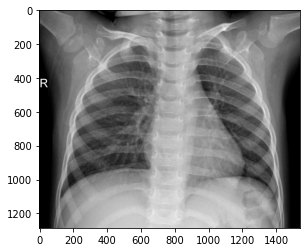

In [7]:
train_normal_names[1]
# 'IM-0544-0001.jpeg'
img = mpimg.imread(os.path.join(train_normal_dir,'IM-0544-0001.jpeg'))
plt.imshow(img, cmap = 'gray')

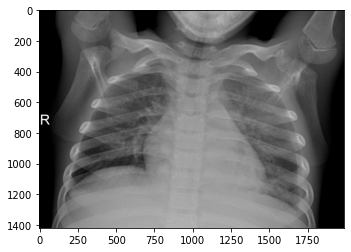

In [0]:
train_pneumonia_names[1]
# 'person297_virus_614.jpeg'
img = mpimg.imread(os.path.join(train_pneumonia_dir, 'person297_virus_614.jpeg'))
plt.imshow(img, cmap = 'gray')

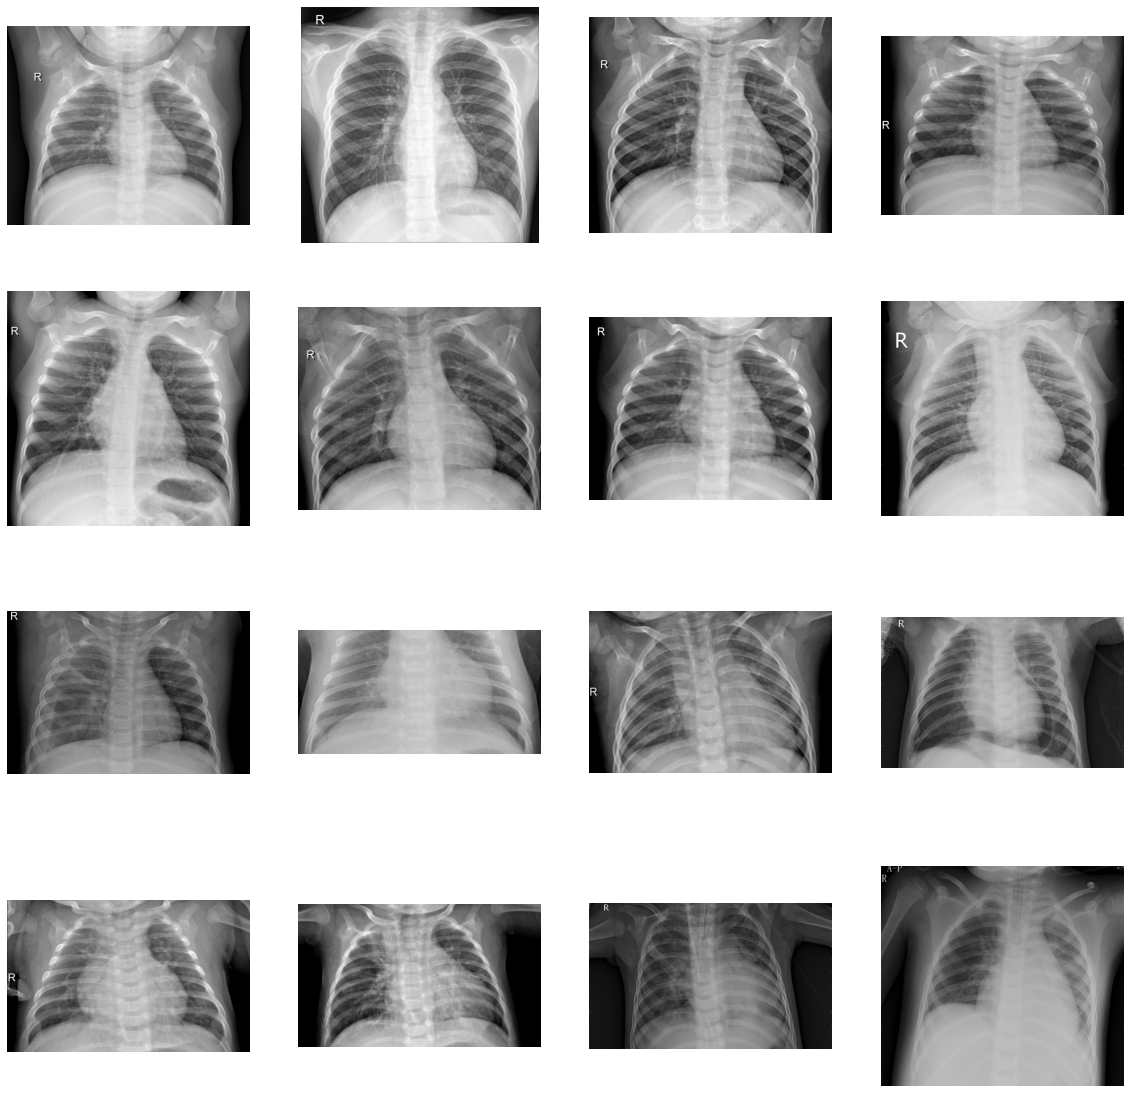

In [0]:
# parameters for graph
nrows = 4
ncols = 4


fig = plt.gcf() #get the current image
fig.set_size_inches(20, 20) #image size

next_normal_pix = [os.path.join(train_normal_dir, fname) 
                    for fname in train_normal_names[0:8]]
next_pneumonia_pix = [os.path.join(train_pneumonia_dir, fname)
                      for fname in train_pneumonia_names[0:8]]

for i, img_path in enumerate(next_normal_pix + next_pneumonia_pix):
  # set up subplot
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img, cmap = 'gray')

plt.show() 

In [0]:
model = tf.keras.models.Sequential([
  
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
  
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
  
    # The fifth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'), # 512 neuron hidden layer
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for ('normal') clas and 1 for ('pneumonia') class
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 33, 33, 128)      

In [0]:
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics = ['accuracy'])

In [42]:
train_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
    '/tmp/chest_xray/chest_xray/train/',
    target_size = (300,300),
    batch_size = 128,
    class_mode = 'binary'
)

validation_generator = test_datagen.flow_from_directory(
    '/tmp/chest_xray/chest_xray/val/',
    target_size = (300, 300),
    batch_size = 128,
    class_mode = 'binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [43]:
history = model.fit(
    train_generator,
    steps_per_epoch = 10,
    epochs = 10,
    validation_data = validation_generator
)

Epoch 1/10
10/10 [==============================] - 15s 1s/step - loss: 0.7844 - accuracy: 0.6734 - val_loss: 0.9010 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 15s 1s/step - loss: 0.5956 - accuracy: 0.7336 - val_loss: 0.7336 - val_accuracy: 0.5000
Epoch 3/10
10/10 [==============================] - 15s 1s/step - loss: 0.6269 - accuracy: 0.7039 - val_loss: 0.7356 - val_accuracy: 0.5000
Epoch 4/10
10/10 [==============================] - 14s 1s/step - loss: 0.4035 - accuracy: 0.8077 - val_loss: 0.5065 - val_accuracy: 0.7500
Epoch 5/10
10/10 [==============================] - 15s 1s/step - loss: 0.5325 - accuracy: 0.7859 - val_loss: 0.9831 - val_accuracy: 0.6250
Epoch 6/10
10/10 [==============================] - 15s 2s/step - loss: 0.3230 - accuracy: 0.8625 - val_loss: 0.6376 - val_accuracy: 0.7500
Epoch 7/10
10/10 [==============================] - 15s 1s/step - loss: 0.3065 - accuracy: 0.8680 - val_loss: 0.3331 - val_accuracy: 0.8750
Epoch 8/10
10/10 [==

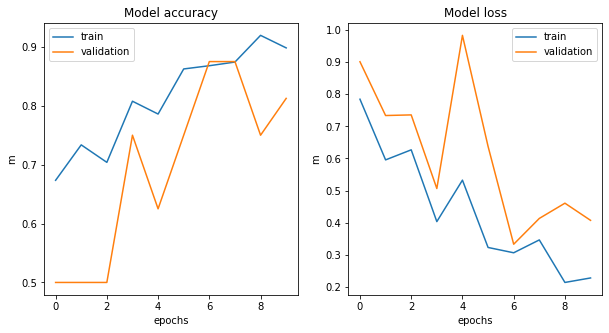

In [44]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,5)

metric = ['accuracy', 'loss']
for i, m in enumerate(metric):
  ax[i].plot(history.history[m])
  ax[i].plot(history.history['val_'+ m])
  ax[i].set_title('Model {}'.format(m))
  ax[i].set_xlabel('epochs')
  ax[i].set_ylabel('m')
  ax[i].legend(['train', 'validation'])


In [49]:
# load new unseen dataset
test_datagen = ImageDataGenerator(rescale = 1/255)

test_generator = test_datagen.flow_from_directory(
    '/tmp/chest_xray/chest_xray/val/',
    target_size = (300, 300),
    batch_size = 128, 
    class_mode = 'binary'
)

eval_result = model.evaluate_generator(test_generator, 16)
print('loss rate at evaluation data :', eval_result[0])
print('accuracy rate at evaluation data :', eval_result[1])

Found 16 images belonging to 2 classes.
loss rate at evaluation data : 0.4074326455593109
accuracy rate at evaluation data : 0.8125


Saving person1946_bacteria_4874.jpeg to person1946_bacteria_4874.jpeg
[1.]
person1946_bacteria_4874.jpeg is pneumonia


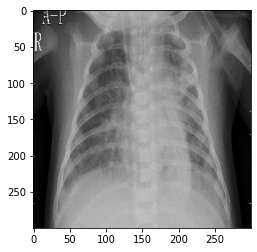

In [0]:
uploaded = files.upload()

for fn in uploaded.keys():
  # predict images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300,300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis =0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)
  print(classes[0])
  if classes[0]> 0.5:
    print(fn + ' is pneumonia')
    plt.imshow(img)
  else:
    print(fn + 'is normal')
    plt.imshow(img)